# Numerical Optimization & Large Scale Linear Algebra
## Assignment 3 - PageRanking

---
> Kostis Konstantinos (p3352311) <br/>
> Athens University Of Economics And Business <br/>
> MSc Data Science - Part Time

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse import csr_matrix, csc_matrix
from scipy.sparse.linalg import splu
import time

%matplotlib inline

## Loading the graph data and creating the P matrix

In this section the web pages of standford are loaded from the zip file. \
Then the P matrix (probability transition matrix) is constructed
appropriately using the sparse matrix technique as it was indicated in the lectures.

In [2]:
data = pd.read_csv('stanweb.dat/stanweb.dat', names = ['source', 'target', 'transition_probability'], sep='\t', header=None)

In [3]:
# Construct P as a sparse representation
def create_sparse_graph(df):
    df['source'] = df['source'].astype(int)
    df['target'] = df['target'].astype(int)

    n = df.source.max()

    # Python starts counting from zero
    row = df.source - 1
    column = df.target - 1
    propabilities = df.transition_probability

    p_mat = csr_matrix((propabilities, (row, column)), shape=(n, n))

    return p_mat

In [4]:
P = create_sparse_graph(data)

In [5]:
# The shape of the matrix
P.shape

(281903, 281903)

## Part 1

## a. Find the pageranking vector $\pi$

Firstly a set of classes is created as needed abstracttions.\
One for the Power-Method technique and one for the system-of-equations using the Gauss-Seidel. \
Each class contains attributes for recording the ranking vector and the time it took to run the specified algorithm.

The setup of parameters involves:

- $\alpha = 0.85$
- $τ = 10^{−8}$

### i) PageRanking using the Power-Method

The implementation refers in the given PDF described in the formula (1) of the section 5.1 of the given PDF and is essentially:

$x^{(k)T} = \alpha x^{(k-1)T} P + (\alpha x^{(k-1)T} a + (1 - \alpha))v^T $

In [6]:
class PowerMethodPageRank:
    def __init__(self, alpha = 0.85, tol=1e-8, persist_topk=None, max_iter=2000):
        self.alpha = alpha
        self.tol = tol

        self.identifier = "power-method-{}".format(self.alpha)
        self.method_name = "Power-Method"

        # A max iterations is set by default to 2000
        # in case the ranking does not converge (due to some
        # numerical instability or glitch)
        self.max_iter = max_iter

        # The following are needed for question c (for the convergence of the components)
        self.persist_topk = persist_topk
        self.top_nodes = []
        self.bottom_nodes = []

        # The pageranking vector
        self.x = None
        
        # The running time measured in milliseconds
        self.runtime_ms = 0.0

        # The number of iterations until convergence
        self.n_iterations = 0

        # The error history (error per iteration)
        self.error_history = []

    def updated_ranking(self, G, alpha, x_prev, a, vT):
        """
        This is the formula (1) of the section 5.1 of the given PDF file DeeperInsidePR.
        It is the new pageranking vector.
        """

        # Important: The * is used for all types of multiplications.
        # This is because if np.dot is used for matrix/vector and vector/vector
        # multplications, then the computation blows up because scipy tries
        # to unroll the sparse matrix into a non-sparse and Jupyter crashes.
        return alpha*x_prev*G + (alpha*x_prev*a + (1 - alpha)) * vT

    def fit(self, G):
        """
        Run the pageranking algorithm on graph G
        using the Power-Method technique.
        """

        # Setup start time
        start_time = time.perf_counter()

        n_r, n_c = G.shape

        # Find nodes with no out links
        with_no_outlinks = G.sum(axis=1)==0
        no_outlinks_index = np.argwhere(with_no_outlinks)

        # The a vector having 1 if it is corresponds to a node with no out links and 0 otherwise 
        a = np.zeros(n_r)
        a[no_outlinks_index[:,0]] = 1

        # Initial ranking (equi-probable)
        x_prev = np.ones(n_c) / n_c

        # This could be a personalized vector, but for simplicity it is equi-probable as well.
        vT = np.ones(n_c) / n_c

        # If instructed, persist the top and bottom nodes ranking
        self.persist_top_and_bottom_nodes(x_prev)

        while True:
            self.n_iterations += 1

            # This is the formula (1) of the section 5.1 of the given PDF file DeeperInsidePR.
            # It is the new pageranking
            x_k = self.updated_ranking(G, self.alpha, x_prev, a, vT)

            self.persist_top_and_bottom_nodes(x_k)

            e = np.linalg.norm(x_k - x_prev, ord=1)
            self.error_history.append(e)

            if (self.n_iterations >= self.max_iter) or (e <= self.tol):
                break

            x_prev = x_k

        self.x = x_k

        end_time = time.perf_counter()

        self.runtime_ms = (end_time - start_time) * 1000

        return self

    def sorted_indices(self, ranking=None):
        """The ranking of the webpages"""
        if ranking is None:
            ranking = self.x

        ascending_indices = ranking.argsort()
        descending_indices = ascending_indices[::-1]

        return descending_indices

    def persist_top_and_bottom_nodes(self, ranking):
        """
        Persist the ranking of the top-k and bottom-k for
        speed of convergennce of the pageranking components.
        """
        if self.persist_topk is not None:
            top_k = self.sorted_indices(ranking)[:self.persist_topk]
            bottom_k = self.sorted_indices(ranking)[-self.persist_topk:]
    
            self.top_nodes.append(top_k)
            self.bottom_nodes.append(bottom_k)

In [7]:
# Run the power-method
power_method_85 = PowerMethodPageRank(alpha = 0.85, tol=1e-8).fit(P)

### ii) PageRanking by solving the corresponding system (via Gauss-Seidel)

The algorithm of Gauss-Seidel that is implemented is based on:

- [Gauss Seidel using matrices](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method)
- The formula (3) of the section 5.2 of the given PDF denoting that the pagerank problem using a system of equations
  is actually formulated as $\pi^T (I - \alpha P) = v^T$

If you look closely the last equation is essentially the known $Ax=b$ system of equations. The **LU** method is used and the system
solution is found iteratively via the rule:

$L x^{k+1} = b - Ux^{k}$

In [8]:
class GaussSeidelPageRank:
    def __init__(self, alpha = 0.85, tol=1e-8, persist_topk=None, max_iter=2000):
        self.alpha = alpha
        self.tol = tol

        self.identifier = "gauss-siedel-{}".format(self.alpha)
        self.method_name = "System Formulation (Gauss Seidel)"

        # A max iterations is set by default to 2000
        # in case the ranking does not converge (due to some
        # numerical instability or glitch)
        self.max_iter = max_iter

        # The following are needed for question c (for the convergence of the components)
        self.persist_topk = persist_topk
        self.top_nodes = []
        self.bottom_nodes = []

        # The pageranking vector
        self.x = None
        
        # The running time measured in milliseconds
        self.runtime_ms = 0.0

        # The number of iterations until convergence
        self.n_iterations = 0

        # The error history (error per iteration)
        self.error_history = []

    def updated_ranking(self, L, U, x_prev, b):
        """
        This is derived from the formula (3) of the section 5.2 of the given PDF file DeeperInsidePR,
        via the LU analysis. It is the new pageranking vector.
        """

        # Important: The * is used for all types of multiplications.
        # This is because if np.dot is used for matrix/vector and vector/vector
        # multplications, then the computation blows up because scipy tries
        # to unroll the sparse matrix into a non-sparse and Jupyter crashes.

        return L.solve(b - U*x_prev)

    def fit(self, G):
        """
        Run the pageranking algorithm on graph G using the iterative Gauss-Seidel system solution technique.
        """

        # Setup start time
        start_time = time.perf_counter()

        n_r, n_c = G.shape

        # Construct the identitu matrix
        I = sparse.identity(n_r,  format = 'csc')

        # Construct A matrix
        A = (I - self.alpha * G)

        # Decompose A using LU
        L = splu(sparse.tril(A, 0,  format = 'csc'))
        U = sparse.triu(A, 1,  format = 'csc')

        # Initial ranking (equi-probable)
        x_prev = np.ones(n_c) / n_c

        # This could be a personalized vector, but for simplicity it is equi-probable as well.
        b = np.ones(n_c) / n_c

        # If instructed, persist the top and bottom nodes ranking
        self.persist_top_and_bottom_nodes(x_prev)

        while True:
            self.n_iterations += 1

            x_k = self.updated_ranking(L, U, x_prev, b)

            self.persist_top_and_bottom_nodes(x_k)

            e = np.linalg.norm(x_k - x_prev, ord=1)
            self.error_history.append(e)
                

            if (self.n_iterations >= self.max_iter) or (e <= self.tol):
                break

            x_prev = x_k

        self.x = x_k

        end_time = time.perf_counter()

        self.runtime_ms = (end_time - start_time) * 1000

        return self

    def sorted_indices(self, ranking=None):
        """The ranking of the webpages"""
        if ranking is None:
            ranking = self.x

        ascending_indices = ranking.argsort()
        descending_indices = ascending_indices[::-1]

        return descending_indices

    def persist_top_and_bottom_nodes(self, ranking):
        """
        Persist the ranking of the top-k and bottom-k for
        speed of convergennce of the pageranking components.
        """
        if self.persist_topk is not None:
            top_k = self.sorted_indices(ranking)[:self.persist_topk]
            bottom_k = self.sorted_indices(ranking)[-self.persist_topk:]
    
            self.top_nodes.append(top_k)
            self.bottom_nodes.append(bottom_k)

In [9]:
# Run the Linear System with Gauss-Seidel
gauss_seidel_85 = GaussSeidelPageRank(alpha=0.85, tol=1e-8).fit(P)

### Helper class for presenting results

In [10]:
# A Helper class for presenting results

class ResultsPresenter:
    """
    A custom class for presenting results of pagerank methods
    with respect to comparison.
    """

    def __init__(self, methods):
        self.methods = methods

    def rankings(self, topk = 20):
        column_names = [method.identifier for method in self.methods]

        df = pd.DataFrame()

        for method in self.methods:
            df[method.identifier] = method.sorted_indices()[:topk]

        df.index = df.index+1

        return df
    
    def runtime_df(self):
        df = pd.DataFrame()

        method_names = []
        method_alpha = []
        method_iterations = []
        method_runtime = []

        for method in self.methods:
            method_names.append(method.identifier)
            method_alpha.append(method.alpha)
            method_iterations.append(method.n_iterations)
            method_runtime.append(method.runtime_ms)

        df['Method'] = method_names
        df['Iterations'] = method_iterations
        df['Runtime (millis)'] = method_runtime

        return df

    def top_and_bottom_pages_convergence_plot(self):
        fig, axes = plt.subplots(len(self.methods), 1, figsize=(12, 16))

        for (method_idx, method) in enumerate(self.methods):
            ax = axes[method_idx]

            top_k_series = np.array(method.top_nodes).mean(axis=1).reshape(-1,1)
            bottom_k_series = np.array(method.bottom_nodes).mean(axis=1).reshape(-1,1)

            ax.plot(top_k_series, label='Top-k pages')
            ax.plot(bottom_k_series, label='Bottom-k pages')

            ax.legend()
            title = "Top-k and Bottom-K convergence speed.\nMethod: {} for alpha={}".format(
                method.method_name, method.alpha)

            ax.set_xlabel('Iterations')
            ax.set_ylabel('Mean Convergence')
            ax.set_title(title)

        plt.show()

    def error_history_plot(self):
        for method in self.methods:
            plt.plot(method.error_history, label=method.identifier)

        plt.legend()
        plt.title('Convergence error VS iterations')
        plt.show()

### Remarks for 1.a

Below you can find the results regarding:

- whether or not the rankings between the 2 methods are the same or not
- which method runs faster

In [11]:
results = ResultsPresenter([power_method_85, gauss_seidel_85])

In [12]:
results.rankings(topk=50)

,power-method-0.85,gauss-siedel-0.85
1,89072,266297
2,226410,139384
3,241453,256035
4,262859,170504
5,134831,210481
6,234703,97798
7,136820,198164
8,68888,62237
9,105606,123572
10,69357,63734


**Remark**

Judging from the top-10 results it seems that running for a=0.85 and t=1e-8 the Power-Method and the Gauss-Seidel give **different** rankings.\
For example: In the first position Power-Method has put the webpage with id=89072 whereas the Gauss-Seidel has put the webpage with id=266297.

In [13]:
results.runtime_df()

,Method,Iterations,Runtime (millis)
0,power-method-0.85,91,407.107764
1,gauss-siedel-0.85,61,4340.148059


**Remark**

As it can be seen the power-method is much faster (around 10 times) than Gauss-Seidel.\
Just for fun, a graph can be found below which depicts the convergence error with respect to the number of iterations, for each method.

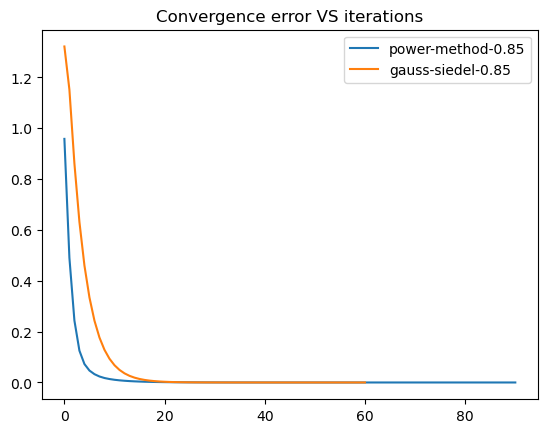

In [14]:
results.error_history_plot()

## b. Do the previous task with $\alpha=0.99$

In [15]:
# Run the power-method, for a=0.99
power_method_99 = PowerMethodPageRank(alpha=0.99, tol=1e-8).fit(P)

# Run the Linear System with Gauss-Seidel, or a=0.99
gauss_seidel_99 = GaussSeidelPageRank(alpha=0.99, tol=1e-8).fit(P)

# Construct a presenter for the results
results = ResultsPresenter([power_method_99, gauss_seidel_99])

In [16]:
results.rankings(topk=50)

,power-method-0.99,gauss-siedel-0.99
1,89072,210481
2,281771,266297
3,174664,256035
4,226410,170504
5,179644,139384
6,271408,198164
7,262859,97798
8,136820,62237
9,68888,123572
10,77987,48415


In [17]:
# Check if the top-50 nodes ranking changed

power_method_ranking_changed = not np.all(power_method_85.sorted_indices()[:50] == power_method_99.sorted_indices()[:50])
gauss_seidel_ranking_changed = not np.all(gauss_seidel_85.sorted_indices()[:50] == gauss_seidel_99.sorted_indices()[:50])

print("Power-Method top-50 ranking changed? ---> {}".format(power_method_ranking_changed))
print("Gauss-Seidel top-50 ranking changed? ---> {}".format(gauss_seidel_ranking_changed))

Power-Method top-50 ranking changed? ---> True
Gauss-Seidel top-50 ranking changed? ---> True


In [18]:
results.runtime_df()

,Method,Iterations,Runtime (millis)
0,power-method-0.99,1392,5773.283056
1,gauss-siedel-0.99,960,18933.137393


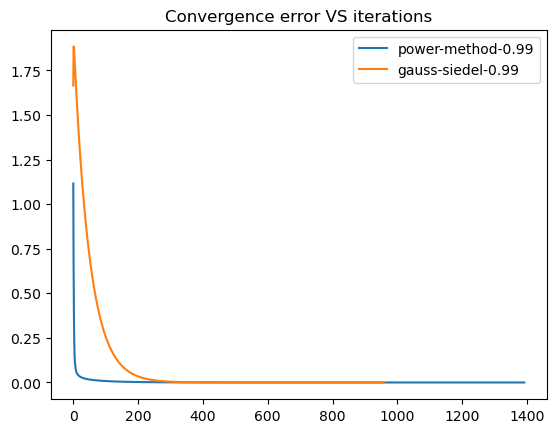

In [19]:
results.error_history_plot()

### Remarks for 1.b

- Of course the running time increased (as expected due to increase of alpha) for both methods. Actually now, the power method is only around 3 times faster than Gauss-Seidel (not 10 times like before)

- Running for a=0.99 resulted in the top-50 rankings to change, for both methods. For example:
  - Power method: The 25th place was previously taken by the node 60209 but this place is now taken by 235495
  - Gauss-Seidel: The 25th place was previously taken by the node 184658 but this place is now taken by 225365

## c. When we use the power method do all the components of $\pi$ converge at the same speed to their limits? Which of them converge faster? Does Gauss-Seidel behave the same way?

In this section, we rerun the pagerank algorithm for both methods, using $\alpha=0.85$, but this time we record the ranking of nodes on each iteration for the top 50 and bottom 50 nodes\
in order to analyze if some components of $\pi$ converge at the same speed to their limits, with respect to both methods (aka Power-Method & Gauss-Seidel System Solution).

Essentially we define a measure of fluctuation as the mean of the ids of the ranked pages. This allows to understand how on each iteration the ids change places.\
The idea is that if the top-k (or bottom-k) pages stop changing places then there is no fluctuation and we can visualize at around which iteration this change happens for a set of
componenents of the $\pi$ vector. It is important to note that the defined metric (aka the mean of node ids) has zero physical meaning.

In [20]:
power_method_c = PowerMethodPageRank(alpha=0.85, tol=1e-8, persist_topk=50).fit(P)
gauss_seidel_c = GaussSeidelPageRank(alpha=0.85, tol=1e-8, persist_topk=50).fit(P)

In [21]:
results = ResultsPresenter([power_method_c, gauss_seidel_c])

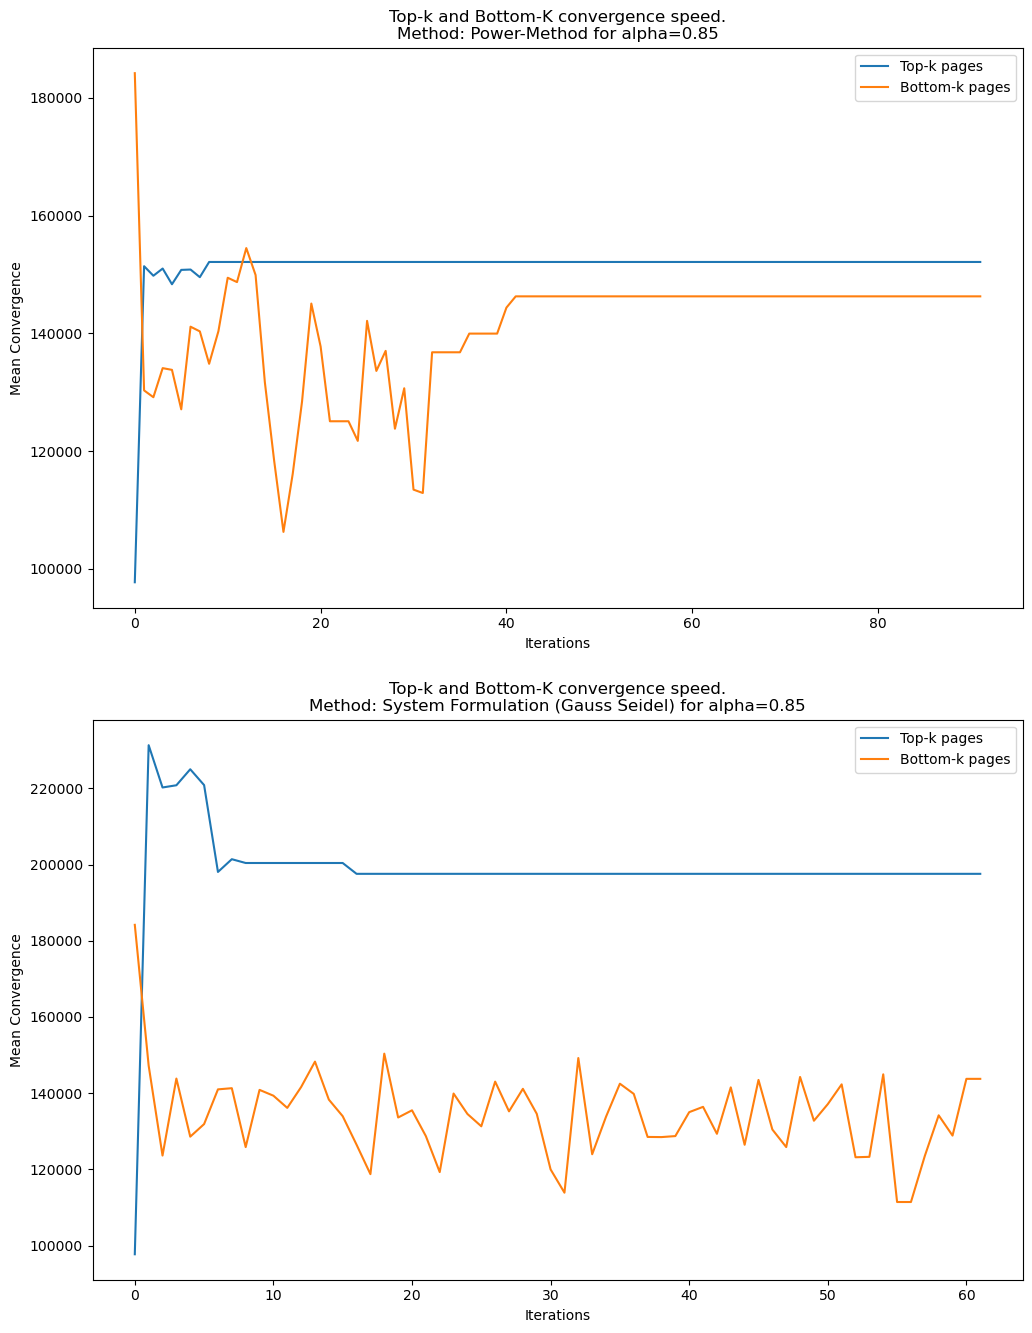

In [22]:
results.top_and_bottom_pages_convergence_plot()

### Remarks for 1.c

- For the Power-Method we observe that, the components that correspond to the important nodes (top-50) converge faster than those which correspond to non-important. More specifically for the top-50 nodes
  this happens before the 20th iteration, while for the bottom-50 nodes this happens after the 40th iteration.
- For the System-Formulation (with Gauss-Seidel) we observe again that the components that correspond to the important nodes converge much faster than those which correspond to non-important. More specifically,
  for the top-50 nodes this happens before the 20th iteration. As opposed to the Power-Method, this time the bottom pages are fluctuating for a much longer time and they stop fluctuating around the end (about the 58th iteration.)

## Part 2

### a. Create a new web page X

In [23]:
# Copy the original graph and add X as a web page
data_with_X = data.copy()
X_index = int(data_with_X.source.max()+1)
data_with_X.loc[len(data_with_X.index)] = [X_index, X_index, 1.0]

# define the new graph as matrix
P_with_X = create_sparse_graph(data_with_X)

In [24]:
P_with_X.shape

(281904, 281904)

In [25]:
# Run the Power-Method Page-Rank (a=0.85)
power_method_with_x = PowerMethodPageRank(alpha=0.85, tol=1e-8).fit(P_with_X)

In [26]:
power_method_85.sorted_indices()[:50]

array([ 89072, 226410, 241453, 262859, 134831, 234703, 136820,  68888,
       105606,  69357,  67755, 225871, 186749, 251795, 272441,  95162,
       119478, 231362,  55787, 167294, 179644,  38341, 117151, 198089,
        60209, 235495, 132694, 181700, 247240, 259454, 120707,  62477,
       161889, 176789, 137631, 221086, 183003,  77998,  17780,  96744,
       112741, 145891, 151427,  81434,  60439, 208541,     90, 214127,
       258347, 222872])

In [27]:
power_method_with_x.sorted_indices()[:50]

array([ 89072, 226410, 241453, 262859, 134831, 234703, 136820,  68888,
       105606,  69357,  67755, 225871, 186749, 272441, 251795,  95162,
       119478, 231362,  55787, 167294, 179644,  38341, 117151, 198089,
        60209, 235495, 132694, 181700, 259454, 247240,  62477, 120707,
       161889,  17780,  77998, 183003, 221086, 137631, 176789,  96744,
       112741, 145891, 151427,  81434,  60439, 208541,     90, 214127,
       258347, 222872])

In [28]:
# Lets count the number of differences in the first 1000 positions
old_rankings = power_method_85.sorted_indices()[:1000]
rankings_with_x = power_method_with_x.sorted_indices()[:1000]

np.sum(old_rankings != rankings_with_x)

142

In [29]:
# Find the position (ranking) of the webpage
# Note: +1 is needed because python counts from zero and we created the matrix by subtracting 1 from the source and target ids
position_of_X=np.where((power_method_with_x.sorted_indices()+1) == X_index)[0][0]
position_of_X

47896

### Remarks for 2.a

- After adding a new webpage X we observe that there are changes even in the top-50 nodes. For example after adding **X** the 29th position which was previously taken by node 247240\
is now taken by the node 259454 which before did not exist in the op-50 nodes. Also, for the first top-1000 positions we observe 142 differences in ranking positions.

- The newly added webpage **X** can be found at the position 47896 - well this is dis-satisfying :-(

### b. Create another page Y

In [30]:
# Augment the webpages by adding Y as a webpage as well
Y_index = int(data_with_X.source.max() +1 )
# Make Y to point to X
data_with_X.loc[len(data_with_X.index)] = [Y_index, X_index, 1.0]

# define the new graph as matrix
P_with_XY = create_sparse_graph(data_with_X)

In [31]:
# Rerun the algorithm and find the rankings of X and Y
power_method_with_xy = PowerMethodPageRank(alpha=0.85, tol=1e-8).fit(P_with_XY)

position_of_X=np.where((power_method_with_xy.sorted_indices()+1) == X_index)[0][0]
position_of_Y=np.where((power_method_with_xy.sorted_indices()+1) == Y_index)[0][0]

In [32]:
print("PageRank of X: {}".format(position_of_X))
print("PageRank of Y: {}".format(position_of_Y))

PageRank of X: 16180
PageRank of Y: 262924


### Remarks for 2.b

Wow, even with one webpage pointing to X, X has a new improved ranking climbing to the position 16180! \
Observe that the rank of **Y** is even lower than the original ranking of **X**

### c. Still unsatisfied, you create a third page Z

Now intuitively, the best setup for the 3 pages in order to maximize the pagerank of X, is to put Y and Z both to point at X.\
This is because no one else in the graph points at X hence, the greater the number of in-links X has the more improved its pagerank will be.

In [33]:
# Copy the original graph and add X, Y and Z as web pages
data_with_XYZ = data.copy()

X_index = int(data_with_XYZ.source.max()+1)
Y_index = int(data_with_XYZ.source.max()+2)
Z_index = int(data_with_XYZ.source.max()+3)

data_with_XYZ.loc[len(data_with_XYZ.index)] = [X_index, X_index, 1.0]
data_with_XYZ.loc[len(data_with_XYZ.index)] = [Y_index, X_index, 1.0]
data_with_XYZ.loc[len(data_with_XYZ.index)] = [Z_index, X_index, 1.0]

# define the new graph as matrix
P_with_XYZ = create_sparse_graph(data_with_XYZ)

In [34]:
# Rerun the algorithm and find the rankings of X , Y and Z
power_method_with_xyz = PowerMethodPageRank(alpha=0.85, tol=1e-8).fit(P_with_XYZ)

position_of_X=np.where((power_method_with_xyz.sorted_indices()+1) == X_index)[0][0]
position_of_Y=np.where((power_method_with_xyz.sorted_indices()+1) == Y_index)[0][0]
position_of_Z=np.where((power_method_with_xyz.sorted_indices()+1) == Z_index)[0][0]

In [35]:
print("PageRank of X: {}".format(position_of_X))
print("PageRank of Y: {}".format(position_of_Y))
print("PageRank of Z: {}".format(position_of_Z))

PageRank of X: 11114
PageRank of Y: 279491
PageRank of Z: 262924


### Remarks for 2.c

The pageranking of **X** is improved even more (reached 11114)

### d. Add links from your page X to older, popular pages. What happens to PageRank of X? You add links from Y or Z to older, popular pages. What happens?

### d.1 Adding links from X to popular pages

The top-20 pages are added as links from X (Y and Z still point to X). Lets see how the PageRank of X changes.

In [36]:
data_with_XYZ = data.copy()

X_index = int(data_with_XYZ.source.max()+1)
Y_index = int(data_with_XYZ.source.max()+2)
Z_index = int(data_with_XYZ.source.max()+3)

# Linking popular pages from X
topk = 20
top_pages = power_method_85.sorted_indices()[:topk]

for top_page_id in top_pages:
    data_with_XYZ.loc[len(data_with_XYZ.index)] = [X_index, top_page_id, 1.0/topk]

# Y and Z point to X
data_with_XYZ.loc[len(data_with_XYZ.index)] = [Y_index, X_index, 1.0]
data_with_XYZ.loc[len(data_with_XYZ.index)] = [Z_index, X_index, 1.0]

P_with_XYZ = create_sparse_graph(data_with_XYZ)

In [37]:
# Rerun the algorithm and find the rankings of X , Y and Z
power_method_with_xyz = PowerMethodPageRank(alpha=0.85, tol=1e-8).fit(P_with_XYZ)

position_of_X=np.where((power_method_with_xyz.sorted_indices()+1) == X_index)[0][0]
position_of_Y=np.where((power_method_with_xyz.sorted_indices()+1) == Y_index)[0][0]
position_of_Z=np.where((power_method_with_xyz.sorted_indices()+1) == Z_index)[0][0]

print("PageRank of X: {}".format(position_of_X))
print("PageRank of Y: {}".format(position_of_Y))
print("PageRank of Z: {}".format(position_of_Z))

PageRank of X: 109090
PageRank of Y: 279491
PageRank of Z: 262924


### Remarks for 2.d - 1

The pagerank of X drops significantly, to position 109090. This is intuitive since the pagerank of the node is penalized because X points to the most
popular pages, but only Y and Z point to X and these 2 pages are not outlinks of any node in the graph. This means that all the page rank that X had was distributed to
the popular pages and in effect its position is demoted.

### d.2 Adding links from Y or Z to popular pages

In this section both Y and Z point to popular pages. Specifically, Y will point to the first top-10 pages and Z to the second top-10 pages.
Y and Z still will point to X.

In [38]:
data_with_XYZ = data.copy()

X_index = int(data_with_XYZ.source.max()+1)
Y_index = int(data_with_XYZ.source.max()+2)
Z_index = int(data_with_XYZ.source.max()+3)

# Add X
data_with_XYZ.loc[len(data_with_XYZ.index)] = [X_index, X_index, 1.0]

# Y and Z point to X
data_with_XYZ.loc[len(data_with_XYZ.index)] = [Y_index, X_index, 1.0/10]
data_with_XYZ.loc[len(data_with_XYZ.index)] = [Z_index, X_index, 1.0/10]

# Linking popular pages from X
topk = 20
top_pages = power_method_85.sorted_indices()[:topk]

for (rank_id, top_page_id) in enumerate(top_pages):
    if rank_id <= 9:
        data_with_XYZ.loc[len(data_with_XYZ.index)] = [Y_index, top_page_id, 1.0/10]
    else:
        data_with_XYZ.loc[len(data_with_XYZ.index)] = [Z_index, top_page_id, 1.0/10]

P_with_XYZ = create_sparse_graph(data_with_XYZ)

In [39]:
# Rerun the algorithm and find the rankings of X , Y and Z
power_method_with_xyz = PowerMethodPageRank(alpha=0.85, tol=1e-8).fit(P_with_XYZ)

position_of_X=np.where((power_method_with_xyz.sorted_indices()+1) == X_index)[0][0]
position_of_Y=np.where((power_method_with_xyz.sorted_indices()+1) == Y_index)[0][0]
position_of_Z=np.where((power_method_with_xyz.sorted_indices()+1) == Z_index)[0][0]

print("PageRank of X: {}".format(position_of_X))
print("PageRank of Y: {}".format(position_of_Y))
print("PageRank of Z: {}".format(position_of_Z))

PageRank of X: 26553
PageRank of Y: 279491
PageRank of Z: 262924


### Remarks for 2.d-2

The pagerank of **X** improved from the previous question reaching the position 26553. Still this position is worse than when Y and Z had X as their only outlink.

### e. Improve the PageRank of X further

As it is evident from the previous sections, when Y and Z pointed to X then its pagerank improved dramatically (from 47896 to 11114). Thus it only makes sense that if some of the most important pages point to **X** then its pagerank would improve even further. So lets test this idea by putting the top-50 pages to point to **X**.

In [40]:
top30 = power_method_85.sorted_indices()[:30]

# Make the top nodes to point to X
for top_page_id in top30:
    data_with_XYZ.loc[len(data_with_XYZ.index)] = [top_page_id, X_index, 1]
    outlinks = len(data_with_XYZ[data_with_XYZ.source == top_page_id].target)
    data_with_XYZ.loc[(data_with_XYZ.source == top_page_id), 'transition_probability'] = 1.0/outlinks

P_linkfarm = create_sparse_graph(data_with_XYZ)

In [41]:
# Rerun the algorithm and find the rankings of X , Y and Z
power_method_linkfarm = PowerMethodPageRank(alpha=0.85, tol=1e-8).fit(P_linkfarm)

position_of_X=np.where((power_method_linkfarm.sorted_indices()+1) == X_index)[0][0]
position_of_Y=np.where((power_method_linkfarm.sorted_indices()+1) == Y_index)[0][0]
position_of_Z=np.where((power_method_linkfarm.sorted_indices()+1) == Z_index)[0][0]

print("PageRank of X: {}".format(position_of_X))
print("PageRank of Y: {}".format(position_of_Y))
print("PageRank of Z: {}".format(position_of_Z))

PageRank of X: 1249
PageRank of Y: 279491
PageRank of Z: 262924


### Remarks for 2.e

We verified that if some of the most popular pages link to **X** then its pagerank is very much improved.\
Specifically putting the top-30 nodes to point at **X** it pageranking moved from the position 11114 to 1249 (which is a huge improvement).